<a href="https://colab.research.google.com/github/pratham9770/eCommerce-Transactions-Analysis/blob/main/DS_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **eCommerce Transaction Analysis**

## **Importing necessary libraries**

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score

# **Task 1: Exploratory Data Analysis (EDA)**




### **Load and preview the dataset**

In [3]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions - Transactions.csv')


print("Preview of Customers Data:")
print(customers.head())

print("\nPreview of Products Data:")
print(products.head())

print("\nPreview of Transactions Data:")
print(transactions.head())

Preview of Customers Data:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Preview of Products Data:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Preview of Transactions Data:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54        

## **Data Pre-processing**

In [4]:
print("\nMissing Values in Each Dataset:")
print("Customers:\n", customers.isnull().sum())
print("\nProducts:\n", products.isnull().sum())
print("\nTransactions:\n", transactions.isnull().sum())


Missing Values in Each Dataset:
Customers:
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Products:
 ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Transactions:
 TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


No significant missing data was observed, so we proceed with the analysis.

### **Convert date columns to datetime objects**

In [8]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])


## **Merge the datasets for easier analysis**

In [9]:
df = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
print("Merged Dataset:\n", df.head())

Merged Dataset:
   TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0        T00001      C0199      P067 2024-08-25 12:38:23         1   
1        T00112      C0146      P067 2024-05-27 22:23:54         1   
2        T00166      C0127      P067 2024-04-25 07:38:55         1   
3        T00272      C0087      P067 2024-03-26 22:55:37         2   
4        T00363      C0070      P067 2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe 2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia 2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe 2024-04-04   
3      601.36   300.68  Travis Campbell  South America 2024-04-11   
4      902.04   300.68    Timothy Perez         Europe 2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Sp

# Exploratory Data Analysis (EDA)

How many orders made by the customers?

Top 5 customers with the most transactions:
     CustomerID  NumTransactions
155      C0156               11
108      C0109               11
174      C0175               10
140      C0141               10
64       C0065               10


<ipython-input-10-4cc7a99266fb>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_transactions["CustomerID"].head(20), y=customer_transactions["NumTransactions"].head(20), palette="viridis")


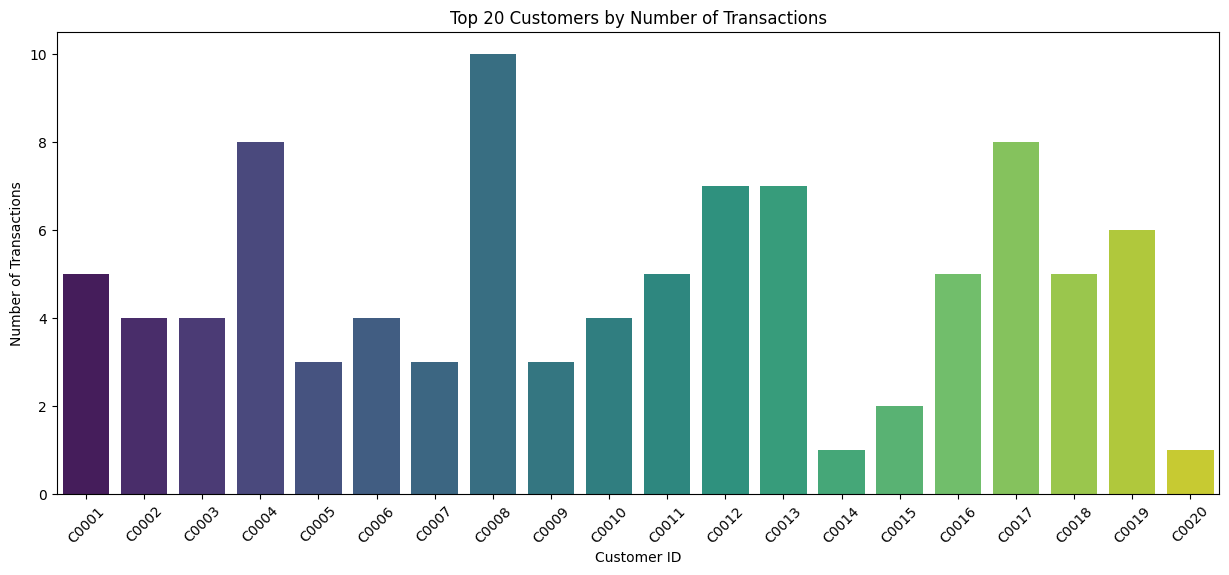

In [10]:
customer_transactions = df.groupby("CustomerID")["TransactionID"].count().reset_index()
customer_transactions.rename(columns={"TransactionID": "NumTransactions"}, inplace=True)


top_customers = customer_transactions.sort_values(by="NumTransactions", ascending=False).head()
print("Top 5 customers with the most transactions:\n", top_customers)


plt.figure(figsize=(15, 6))
sns.barplot(x=customer_transactions["CustomerID"].head(20), y=customer_transactions["NumTransactions"].head(20), palette="viridis")
plt.title("Top 20 Customers by Number of Transactions")
plt.xlabel("Customer ID")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

**Insight 1**-Two customers tied with the highest number of transactions:Customer C0156 and Customer C0109 each made 11 transactions, demonstrating consistent engagement with the platform.

---



How much money spent by the customers?

Top 5 customers by total revenue:
     CustomerID  TotalRevenue
140      C0141      10673.87
53       C0054       8040.39
64       C0065       7663.70
155      C0156       7634.45
81       C0082       7572.91


<ipython-input-11-58dcd71e5636>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=customer_revenue["CustomerID"].head(20), y=customer_revenue["TotalRevenue"].head(20), palette="plasma")


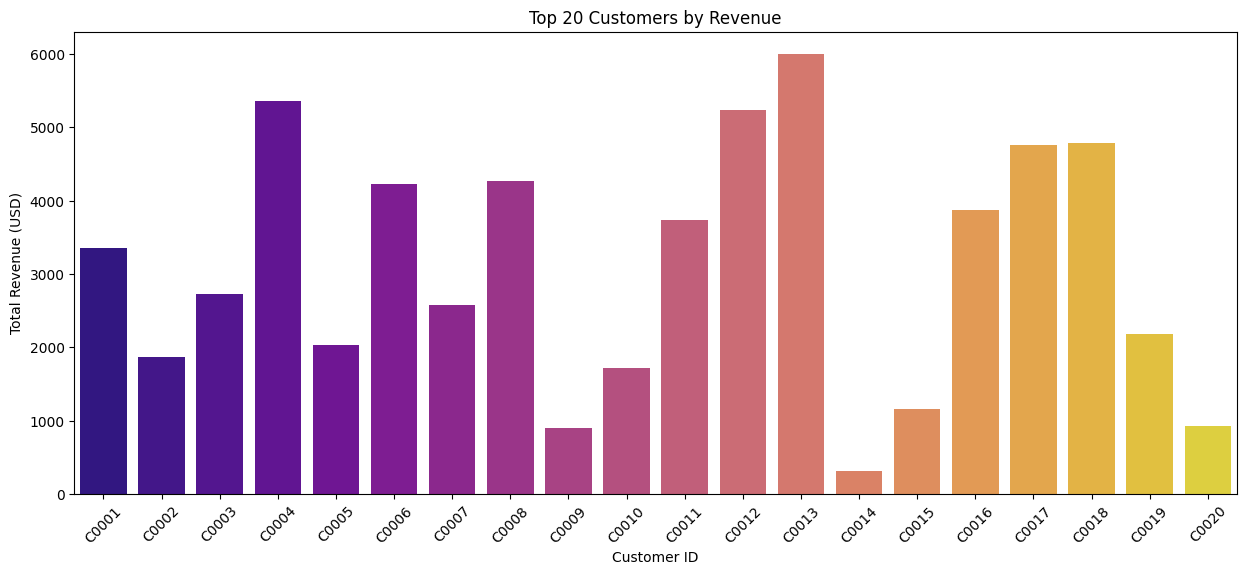

In [11]:
customer_revenue = df.groupby("CustomerID")["TotalValue"].sum().reset_index()
customer_revenue.rename(columns={"TotalValue": "TotalRevenue"}, inplace=True)
top_revenue_customers = customer_revenue.sort_values(by="TotalRevenue", ascending=False).head()
print("Top 5 customers by total revenue:\n", top_revenue_customers)


plt.figure(figsize=(15, 6))
sns.barplot(x=customer_revenue["CustomerID"].head(20), y=customer_revenue["TotalRevenue"].head(20), palette="plasma")
plt.title("Top 20 Customers by Revenue")
plt.xlabel("Customer ID")
plt.ylabel("Total Revenue (USD)")
plt.xticks(rotation=45)
plt.show()


**Insight 2**-With a total spending of $10,673.87, Customer C0141 stands out as the top revenue contributor. This suggests that their purchasing behavior significantly impacts overall business revenue.Notably, Customer C0156 and Customer C0065 appear in both the "most transactions" and "highest revenue" lists. This reflects a combination of frequent purchases and a tendency to buy higher-value items or larger quantities.

---



Discover patterns for each Country

Top 5 Countries by Total Revenue:
          Region  TotalValue
3  South America   219352.56
1         Europe   166254.63
2  North America   152313.40
0           Asia   152074.97


<ipython-input-12-5db2c029b8b9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalValue', y='Region', data=country_revenue_sorted.head(), palette='viridis')


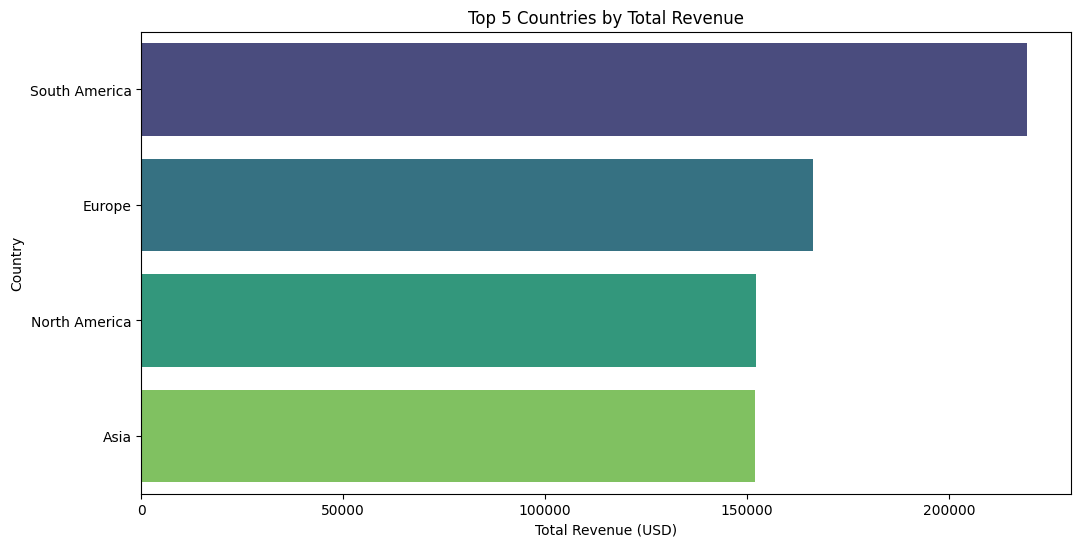

In [12]:
country_revenue = df.groupby('Region')['TotalValue'].sum().reset_index()

# Sort countries by total revenue
country_revenue_sorted = country_revenue.sort_values(by='TotalValue', ascending=False)

# Display top 5 countries by revenue
print("Top 5 Countries by Total Revenue:")
print(country_revenue_sorted.head())

# Plot the total revenue by country
plt.figure(figsize=(12,6))
sns.barplot(x='TotalValue', y='Region', data=country_revenue_sorted.head(), palette='viridis')
plt.title('Top 5 Countries by Total Revenue')
plt.xlabel('Total Revenue (USD)')
plt.ylabel('Country')
plt.show()

**Insight 3**-Despite being a smaller market compared to others, South America is the highest contributor to total revenue with $219,352.56. This suggests that certain regions within South America have customers who spend significantly on the products, possibly indicating a strong demand or a niche market.

---



Analyse Popular Products

Top 5 most sold products:
    ProductID  Quantity          ProductName     Category   Price
58      P059        46      SoundWave Jeans     Clothing  303.20
53      P054        46   SoundWave Cookbook        Books   57.30
28      P029        45   TechPro Headphones  Electronics  433.64
78      P079        43       ActiveWear Rug   Home Decor  417.37
60      P061        43  HomeSense Desk Lamp   Home Decor  156.96


<ipython-input-13-4ab2c5c23abd>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products["ProductName"], y=top_products["Quantity"], palette="magma")


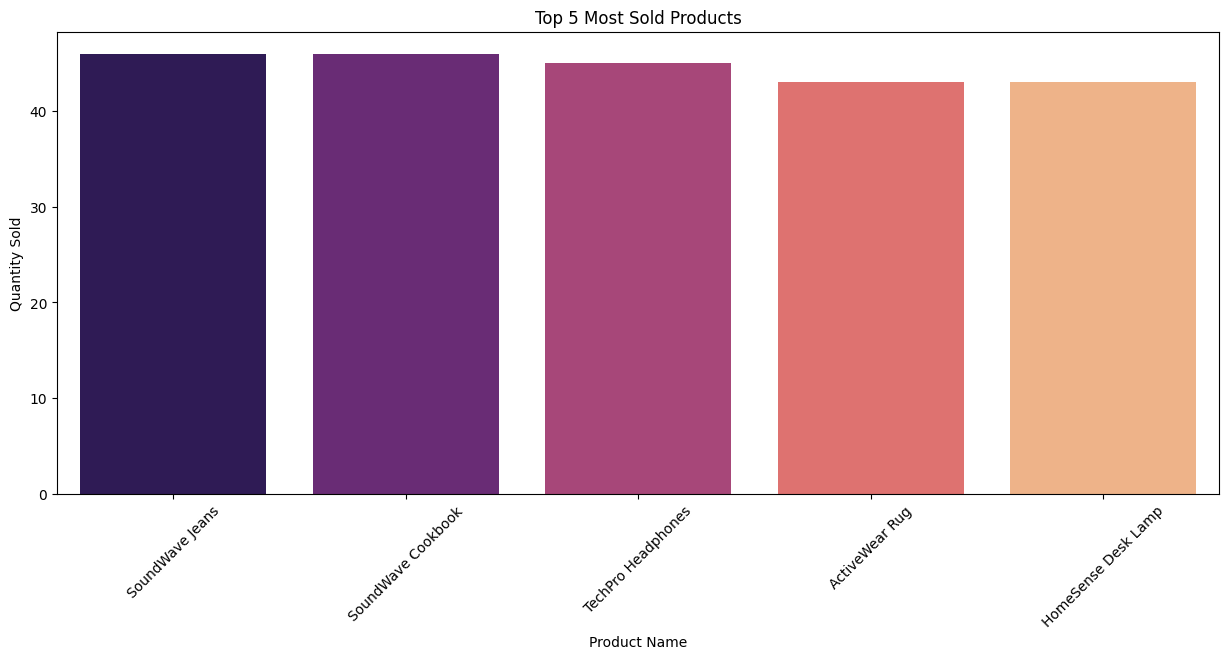

In [13]:
product_sales = df.groupby("ProductID")["Quantity"].sum().reset_index()
product_sales = pd.merge(product_sales, products, on="ProductID", how="left")


top_products = product_sales.sort_values(by="Quantity", ascending=False).head()
print("Top 5 most sold products:\n", top_products)


plt.figure(figsize=(15, 6))
sns.barplot(x=top_products["ProductName"], y=top_products["Quantity"], palette="magma")
plt.title("Top 5 Most Sold Products")
plt.xlabel("Product Name")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.show()

**Insight 4**-The top-selling products indicate a strong demand for high-quality items across various categories. SoundWave Jeans and the SoundWave Cookbook suggest that clothing and books are popular choices among customers, with a focus on premium items. TechPro Headphones highlight the appeal of electronics, while ActiveWear Rug and HomeSense Desk Lamp reflect a growing trend in home decor. The success of these products points to a preference for functional, yet premium, offerings, providing opportunities for upselling and targeted marketing campaigns. Focusing on these categories could further boost sales and customer engagement.

---



Analyze Revenue by Product Category

Revenue by Product Category:
      Category  TotalValue
0        Books   192147.47
2  Electronics   180783.50
1     Clothing   166170.66
3   Home Decor   150893.93


<ipython-input-15-838cc81628f0>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_revenue["Category"], y=category_revenue["TotalValue"], palette="coolwarm")


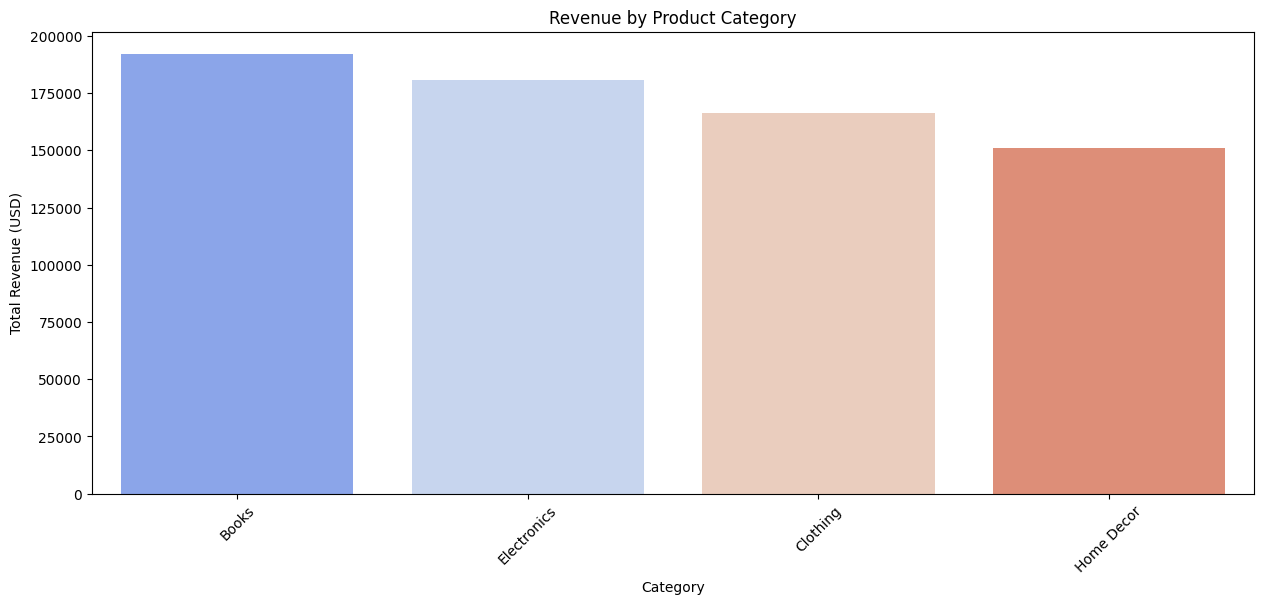

In [15]:
category_revenue = df.groupby("Category")["TotalValue"].sum().reset_index()
category_revenue.sort_values(by="TotalValue", ascending=False, inplace=True)

print("Revenue by Product Category:")
print(category_revenue)

plt.figure(figsize=(15, 6))
sns.barplot(x=category_revenue["Category"], y=category_revenue["TotalValue"], palette="coolwarm")
plt.title("Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Total Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

**Insight 5** -
The revenue breakdown by product category shows that Books lead the sales with a total revenue of USD 192,147.47, followed by Electronics with USD 180,783.50. Clothing comes in third, generating USD 166,170.66, while Home Decor contributes USD 150,893.93. This insight indicates that books and electronics are the top-performing categories, suggesting a high customer interest in educational and tech products.

---



Transaction over time

First Transaction Details:
TransactionID                      T00869
CustomerID                          C0081
ProductID                            P061
TransactionDate       2023-12-30 15:29:12
Quantity                                2
TotalValue                         313.92
Price_x                            156.96
CustomerName              Kimberly Turner
Region                             Europe
SignupDate            2024-02-24 00:00:00
ProductName           HomeSense Desk Lamp
Category                       Home Decor
Price_y                            156.96
MonthYear                         2023-12
TransactionDateDay             2023-12-30
TransactionHour                        15
Year                                 2023
Name: 225, dtype: object


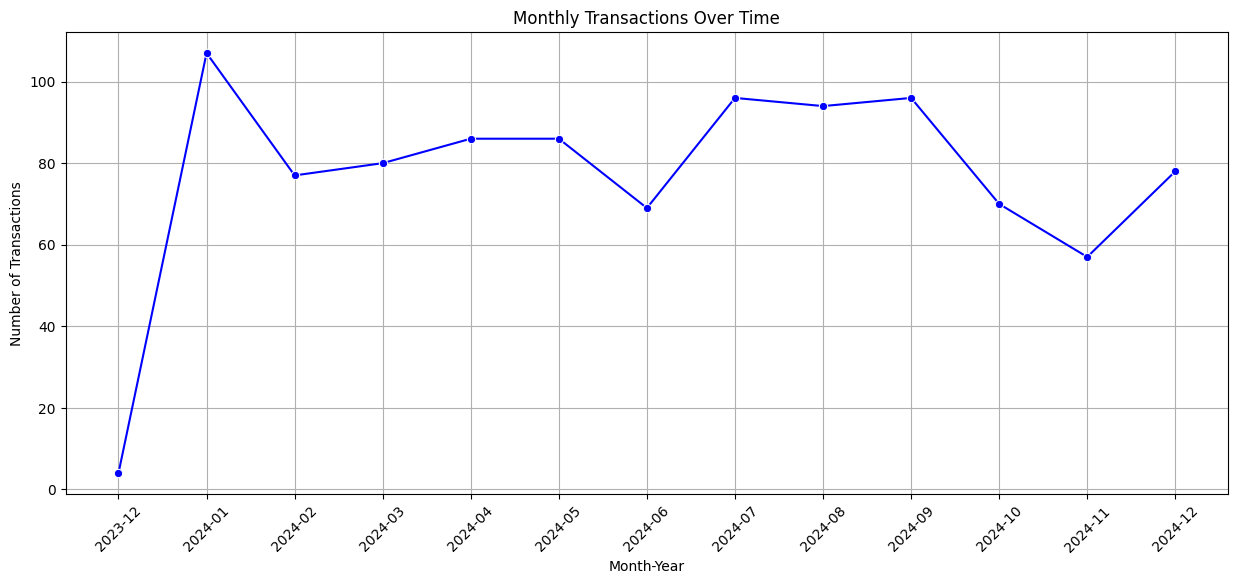

Monthly Transactions Overview (Descending):
  MonthYear  NumTransactions
1   2024-01              107
7   2024-07               96
9   2024-09               96
8   2024-08               94
4   2024-04               86


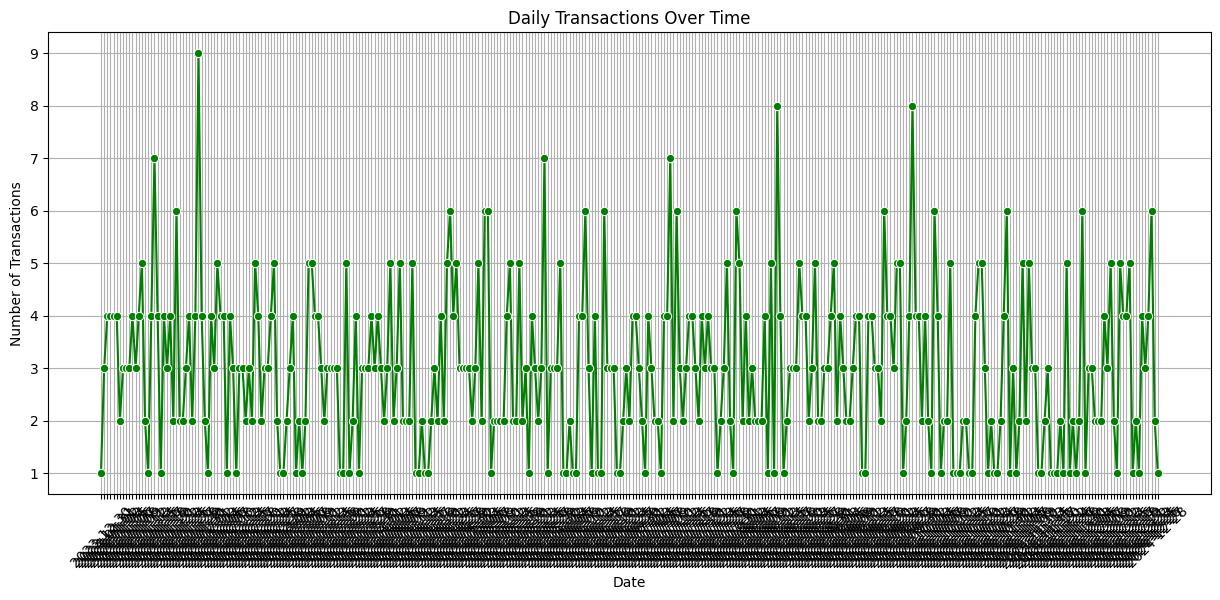

Daily Transactions Overview (Descending):
    TransactionDateDay  NumTransactions
31          2024-01-31                9
258         2024-09-30                8
215         2024-08-15                8
181         2024-07-12                7
141         2024-05-28                7


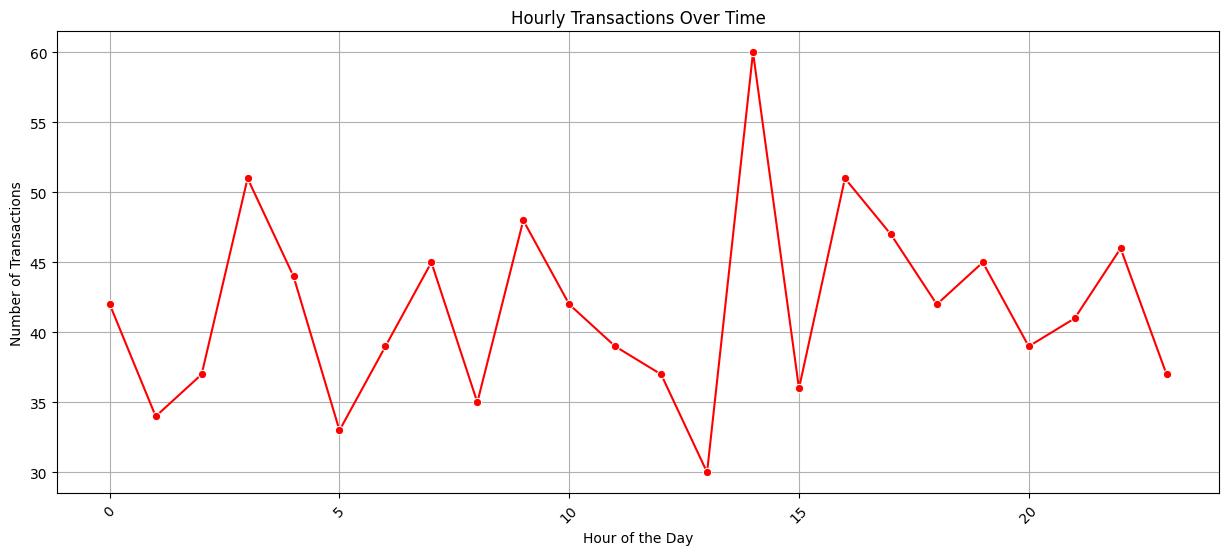

Hourly Transactions Overview (Descending):
    TransactionHour  NumTransactions
14               14               60
16               16               51
3                 3               51
9                 9               48
17               17               47


In [26]:
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

first_transaction = df.sort_values(by="TransactionDate").iloc[0]

# Print the first transaction details
print("First Transaction Details:")
print(first_transaction)
df["MonthYear"] = df["TransactionDate"].dt.to_period("M")


monthly_transactions = df.groupby("MonthYear")["TransactionID"].nunique().reset_index()
monthly_transactions.rename(columns={"TransactionID": "NumTransactions"}, inplace=True)


plt.figure(figsize=(15, 6))
sns.lineplot(x=monthly_transactions["MonthYear"].astype(str), y=monthly_transactions["NumTransactions"], marker="o", color="b")
plt.title("Monthly Transactions Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid()
plt.show()
monthly_transactions.sort_values(by="NumTransactions", ascending=False, inplace=True)

print("Monthly Transactions Overview (Descending):")
print(monthly_transactions.head())

df["TransactionDateDay"] = df["TransactionDate"].dt.date
daily_transactions = df.groupby("TransactionDateDay")["TransactionID"].nunique().reset_index()
daily_transactions.rename(columns={"TransactionID": "NumTransactions"}, inplace=True)


plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_transactions["TransactionDateDay"].astype(str), y=daily_transactions["NumTransactions"], marker="o", color="g")
plt.title("Daily Transactions Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid()
plt.show()
daily_transactions.sort_values(by="NumTransactions", ascending=False, inplace=True)

print("Daily Transactions Overview (Descending):")
print(daily_transactions.head())

df["TransactionHour"] = df["TransactionDate"].dt.hour
hourly_transactions = df.groupby("TransactionHour")["TransactionID"].nunique().reset_index()
hourly_transactions.rename(columns={"TransactionID": "NumTransactions"}, inplace=True)


plt.figure(figsize=(15, 6))
sns.lineplot(x=hourly_transactions["TransactionHour"], y=hourly_transactions["NumTransactions"], marker="o", color="r")
plt.title("Hourly Transactions Over Time")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid()
plt.show()
hourly_transactions.sort_values(by="NumTransactions", ascending=False, inplace=True)

print("Hourly Transactions Overview (Descending):")
print(hourly_transactions.head())


**Insight 6-**
The first transaction occured on December 30, 2021.

*   The month with the highest number of transactions is January 2024 with 107 transactions.The months July 2024 and September 2024 each recorded 96 transactions, showing a high transaction volume in mid-year months.
*   The most active transaction hour is 2:00 PM (14:00), with 60 transactions, followed by 4:00 PM (16:00) and 3:00 AM (03:00) with 51 transaction each, suggesting that peak sales occur in the afternoon.

---






Total Revenue Generated

Revenue by Year (Descending):
   Year  TotalValue
1  2024   686226.04
0  2023     3769.52


<ipython-input-28-3731ed38f007>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Year", y="TotalValue", data=yearly_revenue, palette="viridis")


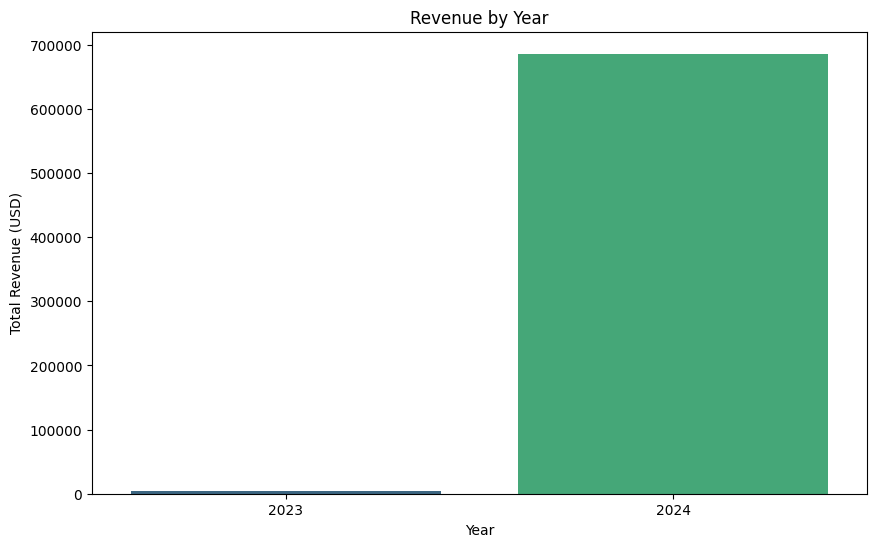

Total Products Sold: 2537
Average number of products bought per transaction: 2.53


In [28]:



df["Year"] = df["TransactionDate"].dt.year


yearly_revenue = df.groupby("Year")["TotalValue"].sum().reset_index()

# Sort by revenue in descending order
yearly_revenue.sort_values(by="TotalValue", ascending=False, inplace=True)


print("Revenue by Year (Descending):")
print(yearly_revenue)

plt.figure(figsize=(10, 6))
sns.barplot(x="Year", y="TotalValue", data=yearly_revenue, palette="viridis")
plt.title("Revenue by Year")
plt.xlabel("Year")
plt.ylabel("Total Revenue (USD)")
plt.show()

total_products_sold = df["Quantity"].sum()
print(f"Total Products Sold: {total_products_sold}")

customer_products = df.groupby('CustomerID')['Quantity'].sum()
customer_transactions = df.groupby('CustomerID')['TransactionID'].nunique()
avg_products_per_transaction = (customer_products / customer_transactions).mean()
print(f"Average number of products bought per transaction: {avg_products_per_transaction:.2f}")



**Insight 7**-The total revenue for the dataset is the sum of the revenue across all years, which amounts to USD 689,995.56, 2024 saw a total revenue of USD 686,226.04, while 2023 only contributed USD 3,769.52.
The total number of products sold is 2,537, with an average of 2.53 products purchased per transaction. This indicates that, on average, each customer buys slightly more than two products per transaction.

---



# Insights Into E-Commerce Transactions Report

As we have thoroughly explored the e-commerce data set through EDA, there are some important e-commerce insights regarding customer actions, sales, and product shifts that will be useful to you.

| Metric                              | Value         |
|-------------------------------------|---------------|
| Total Sales                         | 690995.56 USD |
| Total Products Sold                 | 2537          |
| Average Products per Transaction    | 2.53          |
| ----------------------------------- | ------------- |
| Category                            | Total Revenue |
|-------------------------------------|---------------|
| Books                               | 192147.47     |
| Electronics                         | 180783.50     |
| Clothing                            | 166170.66     |
| Home Decor                          | 150893.93     |




---





1. Behavioral Patterns of E Commerce Transactions:
The maximum and Minimum transactions is characterized throughout the year and indicative of customer fluctuations. The number of transactions was highest in January 2024 and there was a spike on 31st January 2024 as well. These times of the year tend to be critical for the business. The peak hours of transactions are always followed during the afternoon at 2 pm and 4 pm, most likely corresponding to customer activity during midday breaks. These insights are invaluable for making informed decisions regarding targeting efforts and sales tactics.

2. Countries Contribution Towards Revenue: Using the overview of revenue generated from the different countries, South America and Europe took the first place when deemed fit for collected revenue most efficiently. This was led by South America at USD 219,352.56 and seconded by Europe at USD 166,254.63. To a lower amount, North America and Asia also substantiated great contributions.

3. Dynamics of Buying Behavior: At the individual level, an analysis apportioned transactions to customers and identified revenue-generating customers. C0141 customer ranked first with a spend over USD 10,000 while C0054 and C0065 followed closely. These customers are an extremely important segment to the business, and therefore need to be actively retained. Diverted attention to increasing customer loyalty while providing real value through unique offers would add to the value of these customers. Furthermore, the company should consider looking into these customers buying habits to see where they can sell more to them or where they can sell something else.

4. Market Segment Performance: High selling categories included Books, Electronics, and Clothing with sales revenue ranking first from books at USD 192,147.47. This demonstrates the availability of educational and informational products which could be useful to develop new products for sale in the future. Furthermore, the popular selling items such as the SoundWave Jeans and TechPro Headphones show considerable interest in fashion and technology, consistent with market demand.

5. Temporal Insights: Like revenue and transactions, transactions occurring over the course of the day also varied, peaking around 2 PM to 4 PM. Seasonal changes were present as well, with the most revenue generated in 2024, which indicates the recent marketing campaigns and product launches were effective.

Conclusion

These insights reinforce the notion of planning strategies according to the time-based and country specific focus for e commerce. Effective marketers can garner profitability by energizing customer insights, evaluating product performances, and leveraging transactional data to elevate the marketing, inventory, and customer engagement strategies. Furthermore, getting to know the periods along with the regions the company performs best gives them the capacity to make better decisions in anticipation of maximizing growth and customer satisfaction.




# **Task 2: Lookalike Model**

Creating customer profile: The first step involves preparing the customer data to form profiles that can be used for similarity analysis. We started with a dataset that contains transaction-level data (i.e., transaction ID, customer ID, product purchased, quantity, and total value). Our goal was to aggregate this data to form a profile for each customer.

In [30]:
customer_profiles = df.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'TotalValue': 'sum',
    'Category': lambda x: x.mode()[0]  # Most common category
}).reset_index()

One-hot encode the 'Category' column: Since the 'Category' column is categorical, we need to convert it into a numerical format to make it compatible with machine learning models. This is done using one-hot encoding, which converts each category into a binary feature (0 or 1) for each customer.

Calculate cosine similarity between customer profiles: With the customer profiles prepared, the next step is to calculate the similarity between customers based on their aggregated features. We use cosine similarity to measure how similar two customer profiles are, which is widely used in recommendation systems.

In [31]:
customer_profiles = pd.get_dummies(customer_profiles, columns=['Category'])

similarity_matrix = cosine_similarity(customer_profiles.iloc[:, 1:])

Generate lookalike recommendations for each customer: For each customer, we find the top 3 most similar customers based on their cosine similarity scores. These are the customers who are most likely to have similar purchasing patterns.

In [33]:
lookalike_results = {}
for i, customer_id in enumerate(customer_profiles['CustomerID']):
    similar_customers = sorted(
        [(customer_profiles['CustomerID'][j], similarity_matrix[i][j])
         for j in range(len(customer_profiles)) if i != j],
        key=lambda x: x[1], reverse=True
    )[:3]
    lookalike_results[customer_id] = similar_customers


lookalike_df = pd.DataFrame([
    {'CustomerID': cust, 'Lookalikes': lookalikes}
    for cust, lookalikes in lookalike_results.items()
])


lookalike_df = lookalike_df[lookalike_df['CustomerID'].isin([f'C{i:04}' for i in range(1, 21)])]


lookalike_df.to_csv('Lookalike.csv', index=False)

## **Task 3: Customer Segmentation / Clustering**

Applying k-means, DBSCAN clustering and assesing it using DB index

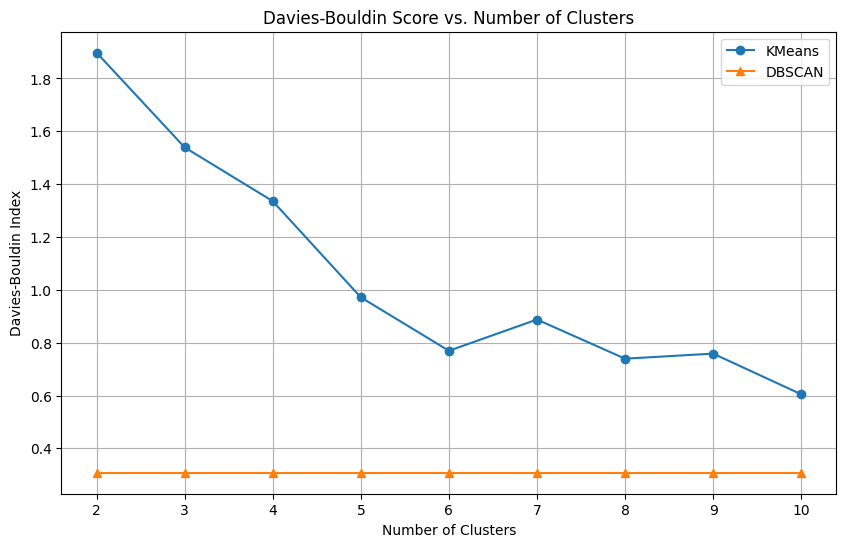

KMeans Clustering:
Lowest DB Score: 0.6048217346183928 at 10 clusters
Average DB Score: 1.055932170276536
Maximum DB Score: 1.8973846334988684

DBSCAN Clustering:
Lowest DB Score: 0.30785229578119405 at 2 clusters
Average DB Score: 0.30785229578119405
Maximum DB Score: 0.30785229578119405


In [44]:

scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profiles.iloc[:, 1:])

k_range = range(2, 11)
db_scores_kmeans = []
db_scores_dbscan = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_profiles['KMeans_Cluster'] = kmeans.fit_predict(scaled_data)
    db_score = davies_bouldin_score(scaled_data, customer_profiles['KMeans_Cluster'])
    db_scores_kmeans.append(db_score)

    dbscan = DBSCAN(eps=0.5, min_samples=5)
    customer_profiles['DBSCAN_Cluster'] = dbscan.fit_predict(scaled_data)
    valid_points = customer_profiles[customer_profiles['DBSCAN_Cluster'] != -1]

    if len(valid_points) > 0:
        db_score = davies_bouldin_score(scaled_data[valid_points.index], valid_points['DBSCAN_Cluster'])
    else:
        db_score = np.nan
    db_scores_dbscan.append(db_score)

plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores_kmeans, label='KMeans', marker='o')
plt.plot(k_range, db_scores_dbscan, label='DBSCAN', marker='^')
plt.title('Davies-Bouldin Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.legend()
plt.grid(True)
plt.show()

min_db_kmeans = min(db_scores_kmeans)
min_db_kmeans_index = db_scores_kmeans.index(min_db_kmeans)
best_kmeans_clusters = k_range[min_db_kmeans_index]

min_db_dbscan = min(db_scores_dbscan)
min_db_dbscan_index = db_scores_dbscan.index(min_db_dbscan)
best_dbscan_clusters = k_range[min_db_dbscan_index]

avg_db_kmeans = np.mean(db_scores_kmeans)
avg_db_dbscan = np.mean(db_scores_dbscan)
max_db_kmeans = max(db_scores_kmeans)
max_db_dbscan = max(db_scores_dbscan)

print("KMeans Clustering:")
print(f"Lowest DB Score: {min_db_kmeans} at {best_kmeans_clusters} clusters")
print(f"Average DB Score: {avg_db_kmeans}")
print(f"Maximum DB Score: {max_db_kmeans}")

print("\nDBSCAN Clustering:")
print(f"Lowest DB Score: {min_db_dbscan} at {best_dbscan_clusters} clusters")
print(f"Average DB Score: {avg_db_dbscan}")
print(f"Maximum DB Score: {max_db_dbscan}")


Clustering Report: The clustering analysis using KMeans and DBSCAN revealed distinct performance trends based on the Davies-Bouldin (DB) score. For KMeans clustering, the lowest DB score was 0.60, achieved with 10 clusters, while the average score across all cluster numbers was 1.06, and the maximum reached 1.90. This indicates that the optimal number of clusters for KMeans appears to be 10, though there is noticeable variation in DB scores across different cluster counts. On the other hand, DBSCAN clustering resulted in a notably lower and more consistent DB score of 0.31, which was recorded for 2 clusters and remained the same across all other configurations. The low DB score for DBSCAN suggests that it performed exceptionally well in terms of compactness and separation, outperforming KMeans in terms of the stability of cluster quality. However, the results indicate that DBSCAN may be more sensitive to the parameters and the data distribution, given its uniform DB score.